# **Color palette clustering: KMeans with palette images in input**



In this notebook we've performed the final and third task of the project: Clustering based on color palette. We used KMeans to extract the color palette from the shots and save the images of the palette in a dedicated folder on the drive. Then we used the first line of pixels of those images for the final clustering. We performed KMeans tuning on this final clustering with elbow method and silhouette score.

# **0. Google Colab Setup**

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "<path>"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "<path>"
GDRIVE_DATA_CSV = GDRIVE_HOME_DIR + "<path>"
RANDOM_SEED = 42

import os
os.environ["JAVA_HOME"] = JAVA_HOME

In [2]:
# Point Colaboratory to our Google Drive
from google.colab import drive
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


# **1. Useful imports**

In [3]:
import PIL.Image as Image
from PIL import ImageFilter
import io

import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
import pandas as pd
import imutils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input

# **2. Dataframe preparation to clustering**

In [4]:
shot_palette_df = pd.read_parquet(GDRIVE_HOME_DIR + "/Big_Data/cluster_colors/K-Means/data/palette_df.parquet")

Here we have our dataset composed by the first line of the images, every column i is the RGB value of the pixel in [0][i] cell of the image

In [7]:
shot_palette_df.head()

,path,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,file:/content/drive/MyDrive/Big_Data/cluster_c...,"[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]",...,"[148, 138, 143]","[129, 91, 84]","[129, 91, 84]","[129, 91, 84]","[129, 91, 84]","[129, 91, 84]","[129, 91, 84]","[60, 14, 10]","[60, 14, 10]","[60, 14, 10]"
1,file:/content/drive/MyDrive/Big_Data/cluster_c...,"[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]",...,"[219, 145, 91]","[143, 118, 116]","[143, 118, 116]","[143, 118, 116]","[143, 118, 116]","[143, 118, 116]","[240, 206, 183]","[240, 206, 183]","[240, 206, 183]","[240, 206, 183]"
2,file:/content/drive/MyDrive/Big_Data/cluster_c...,"[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]",...,"[20, 32, 34]","[20, 32, 34]","[20, 32, 34]","[20, 32, 34]","[205, 211, 200]","[205, 211, 200]","[205, 211, 200]","[205, 211, 200]","[205, 211, 200]","[205, 211, 200]"
3,file:/content/drive/MyDrive/Big_Data/cluster_c...,"[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]",...,"[129, 172, 194]","[129, 172, 194]","[32, 61, 61]","[32, 61, 61]","[32, 61, 61]","[32, 61, 61]","[32, 61, 61]","[217, 234, 238]","[217, 234, 238]","[217, 234, 238]"
4,file:/content/drive/MyDrive/Big_Data/cluster_c...,"[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]",...,"[148, 109, 65]","[148, 109, 65]","[148, 109, 65]","[179, 67, 38]","[179, 67, 38]","[179, 67, 38]","[179, 67, 38]","[179, 67, 38]","[204, 190, 166]","[204, 190, 166]"


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import os

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from collections import Counter
from sklearn.cluster import KMeans

We take only the features

In [8]:
data = shot_palette_df.iloc[:, 1:]

In [9]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,"[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]","[191, 92, 86]",...,"[148, 138, 143]","[129, 91, 84]","[129, 91, 84]","[129, 91, 84]","[129, 91, 84]","[129, 91, 84]","[129, 91, 84]","[60, 14, 10]","[60, 14, 10]","[60, 14, 10]"
1,"[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]","[122, 52, 8]",...,"[219, 145, 91]","[143, 118, 116]","[143, 118, 116]","[143, 118, 116]","[143, 118, 116]","[143, 118, 116]","[240, 206, 183]","[240, 206, 183]","[240, 206, 183]","[240, 206, 183]"
2,"[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[102, 113, 88]","[63, 77, 65]",...,"[20, 32, 34]","[20, 32, 34]","[20, 32, 34]","[20, 32, 34]","[205, 211, 200]","[205, 211, 200]","[205, 211, 200]","[205, 211, 200]","[205, 211, 200]","[205, 211, 200]"
3,"[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]","[96, 132, 149]",...,"[129, 172, 194]","[129, 172, 194]","[32, 61, 61]","[32, 61, 61]","[32, 61, 61]","[32, 61, 61]","[32, 61, 61]","[217, 234, 238]","[217, 234, 238]","[217, 234, 238]"
4,"[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]","[12, 7, 5]",...,"[148, 109, 65]","[148, 109, 65]","[148, 109, 65]","[179, 67, 38]","[179, 67, 38]","[179, 67, 38]","[179, 67, 38]","[179, 67, 38]","[204, 190, 166]","[204, 190, 166]"


In [10]:
data_flattened = np.array([np.concatenate(data.iloc[i, :]) for i in range(len(data))])

In [12]:
data_flattened

array([[191,  92,  86, ...,  60,  14,  10],
       [122,  52,   8, ..., 240, 206, 183],
       [102, 113,  88, ..., 205, 211, 200],
       ...,
       [  0,   0,   0, ...,  64,  92, 105],
       [  0,   0,   0, ...,  96,  96,  96],
       [  0,   0,   0, ..., 103, 103, 102]], dtype=int32)

# **3. Clustering + evaluation**

In [ ]:
import seaborn as sns

def plot_elbow(k_values, cs, silhouette_scores):

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the elbow curve on the first subplot
    sns.lineplot(x=k_values, y=cs, ax=axes[0])
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('CS')

    # Plot the second chart on the second subplot (you can modify this part to plot your desired chart)
    axes[1].plot(silhouette_scores)  # Example data, replace with your own
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_title('Silhouette scores')

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

def k_means_tuning(df_palette, max_k = 30):

  # creating the prediction dataframe
  cs = []
  k_values = range(3, max_k + 1)

  scores = []
  for i in k_values:
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300, n_init = 10, random_state = RANDOM_SEED)
    preds = kmeans.fit_predict(df_palette)
    cs.append(kmeans.inertia_)
    scores.append(silhouette_score(df_palette, preds))

  # Plotting elbow method and TSNE result for the best K
  plot_elbow(k_values, cs, scores)

It seems that K = 12 could be the optimal K

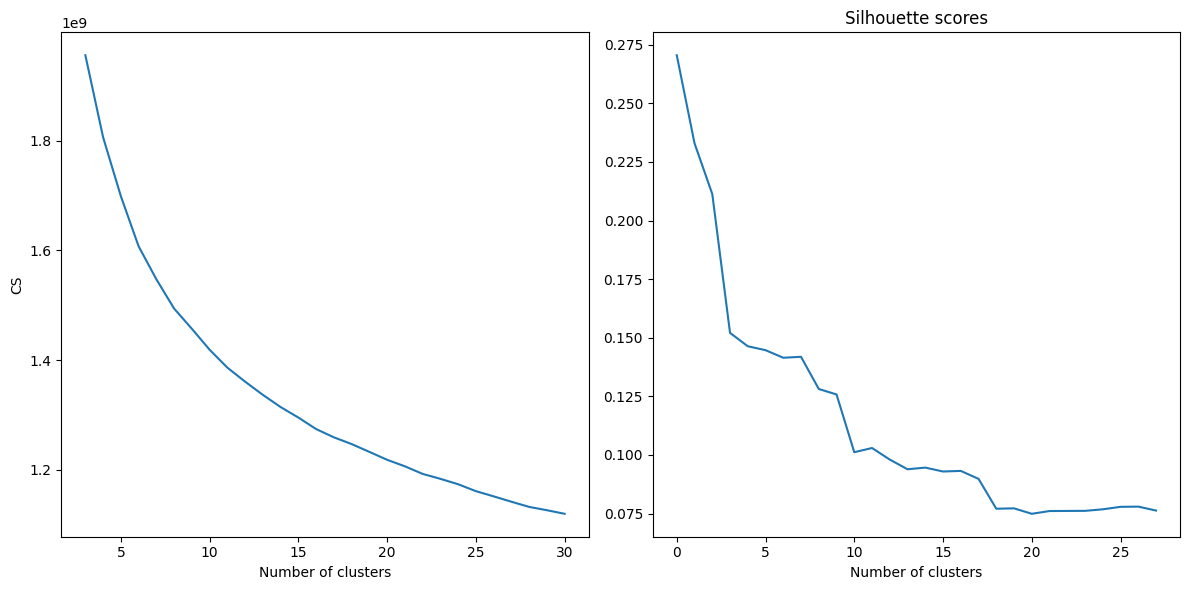

In [ ]:
k_means_tuning(data_flattened)

In [14]:
def apply_kmeans(k, data, filenames):
  # creating the prediction dataframe
  pred_df = pd.DataFrame(filenames, columns = ["filename"])

  # K-Means clustering
  clustering_kmeans = KMeans(n_clusters = k, init = 'random', max_iter = 300, n_init = 10, random_state = RANDOM_SEED)

  pred_df["clusters"] = clustering_kmeans.fit_predict(data)
  return pred_df

# **4. Visualize images and cluster results**

In [15]:
def plot_big_image(pred_df, num_images, shuffle = False):

    list_clusters = pred_df["clusters"].unique().tolist()
    list_clusters.sort()

    f, arr = plt.subplots(2 * len(list_clusters), num_images, figsize = (num_images * 4, 4 * len(list_clusters)))

    for j, num_cluster in enumerate(list_clusters):

        # taking only the rows with num_cluster
        images = pred_df[pred_df["clusters"] == num_cluster]

        # shuffling rows
        if shuffle: images = images.sample(frac=1)

        images = images[:num_images]

        list_img_path = images["filename"].tolist()

        for i, img_path in enumerate(list_img_path):

            list_img_path = img_path.split("/")
            palette_path = "/" + "/".join(list_img_path[1:])
            img_path = GDRIVE_DATA_DIR + "/" + list_img_path[-1]

            # Load the palette
            palette = Image.open(palette_path).resize((50, 10))
            try:
              img = Image.open(img_path) # first try with png
            except:
              try:
                img_path = img_path[:-4] + ".jpg" # then jpg
                img = Image.open(img_path)
              except:
                img_path = img_path[:-4] + ".jpeg" #then jpeg
                img = Image.open(img_path)

            # Plot the image
            arr[2*j, i].imshow(img)
            arr[2*j, i].axis('off')

            # Plot the color palette
            arr[2*j + 1, i].imshow(palette)
            arr[2*j + 1, i].axis('off')

    # Show the plot
    plt.show()

## **K = 12**

In [17]:
pred_df = apply_kmeans(12, data_flattened, shot_palette_df["path"].tolist())

In [23]:
pred_df["clusters"].value_counts()

7     1822
4     1776
1     1061
10     729
8      428
9      416
5      405
6      351
0      301
11     260
3      251
2      200
Name: clusters, dtype: int64

In [ ]:
plot_big_image(pred_df, 10, True)

## **t-SNE**

t-Distributed Stochastic Neighbor Embedding is a popular machine learning algorithm used for visualizing high-dimensional data in a lower-dimensional space.

In [20]:
from sklearn.manifold import TSNE

def apply_tsne(data, pred_df):

    tSNE = TSNE(n_components=2)
    tSNE_result = tSNE.fit_transform(data)

    x = tSNE_result[:,0]
    y = tSNE_result[:,1]

    import pandas as pd
    import seaborn as sns

    colors = len(pd.unique(pred_df["clusters"]))

    df = pd.DataFrame(pred_df["clusters"])
    df['x']=x
    df['y']=y

    plt.figure(figsize=(20,10))
    sns.scatterplot(x='x',y='y',hue='clusters',palette=sns.color_palette("hls", colors),data=df,
                  legend="full")
    plt.show()

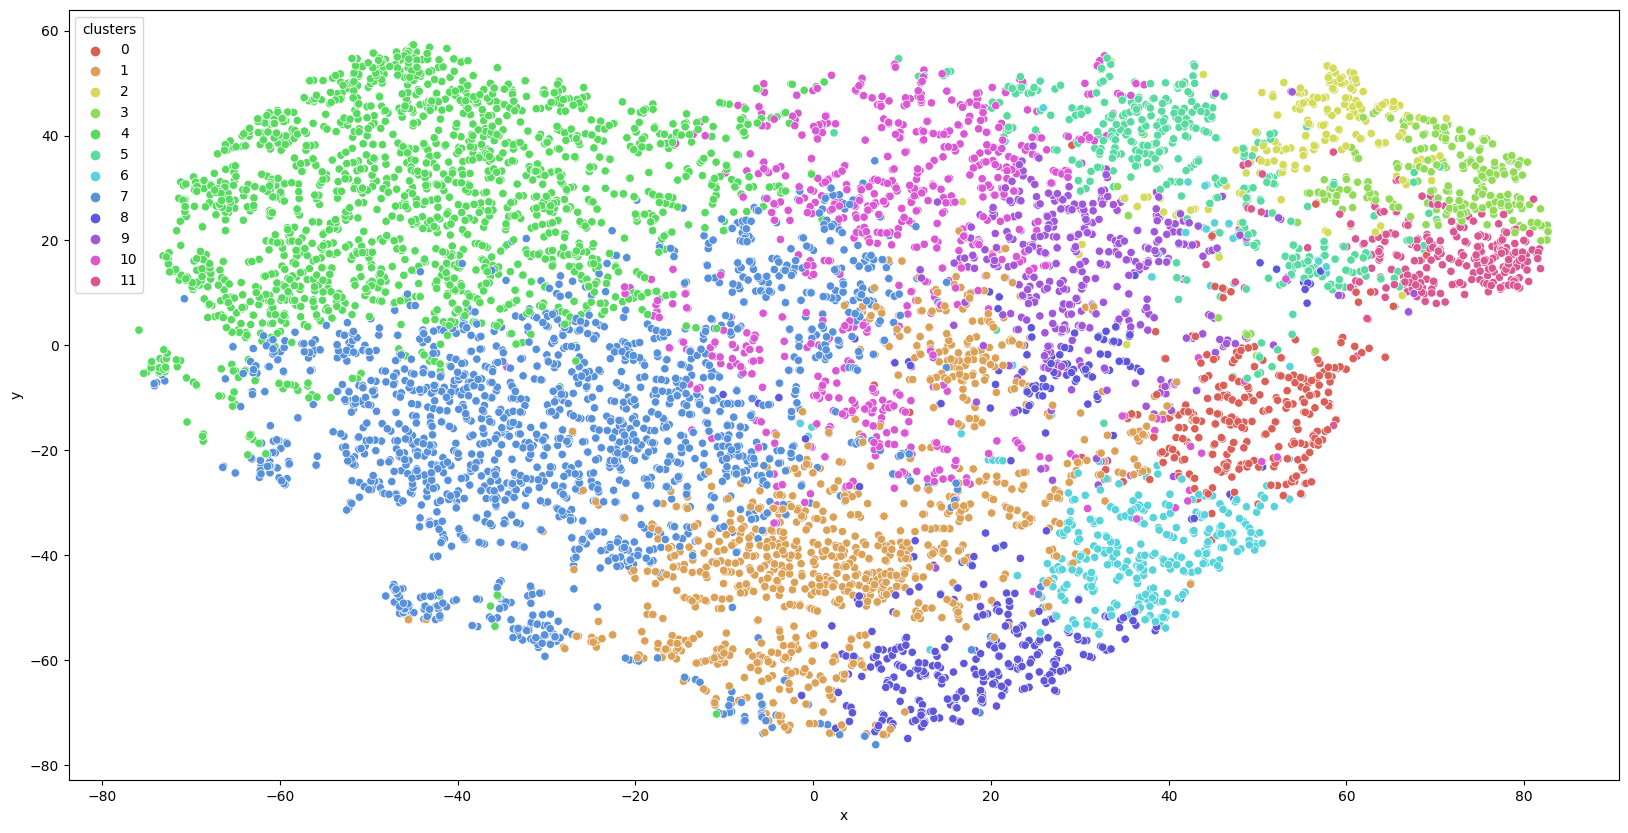

In [21]:
apply_tsne(data_flattened, pred_df)

## **K = 70**

In [24]:
pred_df_70 = apply_kmeans(70, data_flattened, shot_palette_df["path"].tolist())

In [ ]:
plot_big_image(pred_df_70, 5, True)

# **5. Conclusions**

This approach fails in clustering similar color but it does accomplish another type of task, clustering images based on similar color palettes percentage. We can see that every cluster has similar percentages of colors even if the colors are sometimes completely different. it offers a simpler type of clustering beacause it got less data to analyze. It appears to be looking at the general appearance of the image without considering the various aspects of it, while the other paid attention to all those details, like saturation, value and hue.

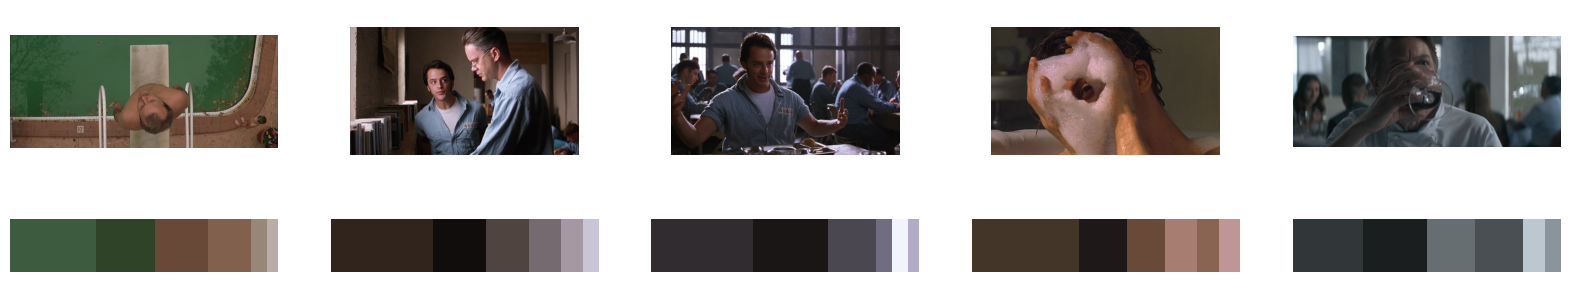

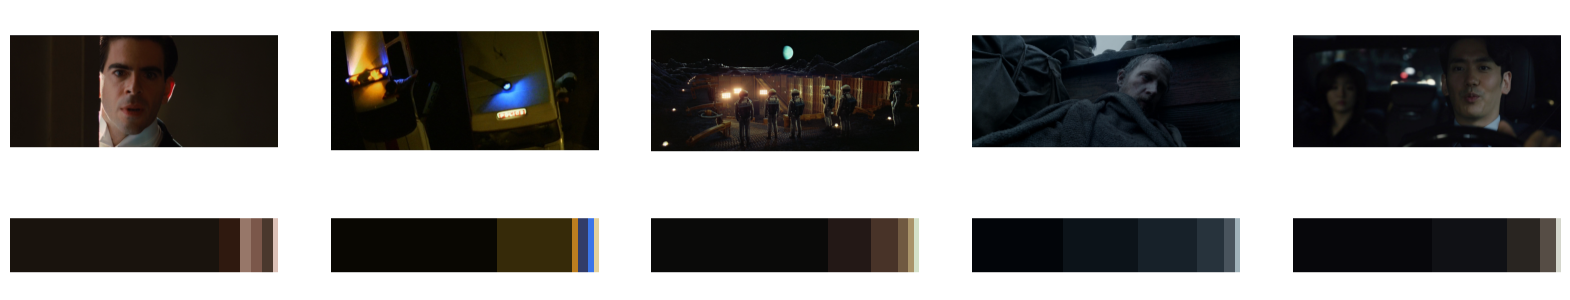